In [87]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import glob
import math
%matplotlib inline

In [88]:
import torch
import torch_dct as dct
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import make_grid

In [89]:
import albumentations as A
import cv2 as cv

In [90]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from PIL import Image
from torch.utils.data import random_split
import torchvision.transforms.functional as TF
from scipy.ndimage import rotate, filters
from skimage.color import rgb2gray

In [91]:
from sklearn.metrics import roc_auc_score, recall_score, f1_score, precision_score, accuracy_score

In [92]:
!PYTORCH_NO_CUDA_MEMORY_CACHING=1
!pip install -U albumentations
import albumentations as A
!pip install kornia
import kornia as K
from sklearn import metrics
import torch.utils.model_zoo as model_zoo
from kornia import morphology as morph
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

'PYTORCH_NO_CUDA_MEMORY_CACHING' is not recognized as an internal or external command,
operable program or batch file.


In [46]:
seed = 200
torch.backends.cudnn.deterministic = True
!CUBLAS_WORKSPACE_CONFIG=:16:8
torch.backends.cudnn.benchmark = False
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.is_available()

'CUBLAS_WORKSPACE_CONFIG' is not recognized as an internal or external command,
operable program or batch file.


False

In [93]:
batch = 10
num_epochs = 1

In [94]:
class keywords:
    TData_train = "D:/YASWANTH/input/defactotrainset/defacto_trainset.xlsx"
    VData_test = "D:/YASWANTH/input/defactotestset/defacto_testset.xlsx"
    splicing = "D:/YASWANTH/input/defactosplicing/splicing_2_annotations/probe_mask"
    casia_model_path = "D:/YASWANTH/input/casia-model/Model.pth"
    TRAIN = 'train'

In [95]:
def prepare(im_root_dir, lab_root_dir, num=2000, mode='test'):
    """
    Prepare the data by reading from Excel and sorting the names and labels.

    Args:
        im_root_dir (str): Root directory for image data.
        lab_root_dir (str): Root directory for label data.
        num (int, optional): Number of data samples to load (default: 2000).
        mode (str, optional): Mode of the dataset (default: 'test').

    Returns:
        tuple: Tuple containing the sorted names and labels.
    """
    name = []
    lab = []

    # Read the data from the Excel
    df = pd.read_excel(im_root_dir)

    # Read the column with name 'name'
    zipta = df['name'].tolist()

    labels = sorted(os.listdir(lab_root_dir))

    for fname in zipta:
        lab_ = [a for a in labels if fname in a]
        lab.append(lab_)

    name = sorted(zipta)
    label = sorted(lab)

    return name, label

In [96]:
transformi = transforms.Compose([
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

transform = A.Compose([
    A.OneOf([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5)
    ], p=1)
], p=0.05)


class dataset(torch.utils.data.Dataset):
    """
    Custom dataset class for image data.
    """

    def __init__(self, im_root_dir, label_root_dir, num, mode='test', transform=None, tra=None):
        """
        Initialize the dataset.

        Args:
            im_root_dir (str): Root directory for image data.
            label_root_dir (str): Root directory for label data.
            num (int): Number of data samples to load.
            mode (str, optional): Mode of the dataset (default: 'test').
            transform: Transformation to apply to the data (default: None).
            tra: Additional transformation parameter (default: None).
        """
        self.im_root_dir = im_root_dir
        self.label_root_dir = label_root_dir
        self.transform = transform
        self.tra = tra
        self.num = num
        self.mode = mode
        name = []
        lab = []
        name, label = prepare(self.im_root_dir, self.label_root_dir, self.num, self.mode)
        self.name = name
        self.label = label

    def __len__(self):
        """
        Get the length of the dataset.

        Returns:
            int: Length of the dataset.
        """
        return len(self.name)

    def transform0(self, sample):
        """
        Apply transformation to the image and mask.

        Args:
            sample (tuple): Tuple containing the image and mask.

        Returns:
            tuple: Transformed image and mask.
        """
        image, mask = sample[0], sample[1]

        n = 256
        image = TF.resize(image, size=(n, n), interpolation=torchvision.transforms.InterpolationMode.BICUBIC)
        mask = TF.resize(mask, size=(n, n), interpolation=torchvision.transforms.InterpolationMode.BICUBIC)

        return image, mask

    def __getitem__(self, idx):
        """
        Get a specific data sample from the dataset.

        Args:
            idx (int): Index of the data sample.

        Returns:
            dict: Dictionary containing the image and label.
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = torch.FloatTensor(cv.imread(f"{keywords.splicing_img}{self.name[idx][:-3]}tif"))

        label = torch.FloatTensor(cv.imread(f"{keywords.splicing}/{self.name[idx][:-3]}jpg", cv.IMREAD_GRAYSCALE))

        if len(label.shape) >= 3:
            label = torch.max(label, 2)

        if self.mode == keywords.TRAIN:
            z = self.tra(image=np.array(image), mask=(np.array(label)))
            x = torch.FloatTensor(z['image'])
            y = torch.FloatTensor(z['mask'])
            x = x.permute(2, 0, 1)
            x = self.transform(x)
            y = y.unsqueeze(0)
            x, y = self.transform0((x / 255.0, y))
            y = y.ge(0.5).float()
        else:
            x = image.permute(2, 0, 1)
            x = self.transform(x)
            y = label.unsqueeze(0) / 255.0
            x, y = self.transform0((x / 255.0, y))
            y = y.ge(0.5).float()

        return {'image': x, 'landmarks': y}

In [97]:
TData = dataset(
    keywords.TData_train,
    keywords.splicing,
    450,
    keywords.TRAIN,
    transformi,
    transform
)

train_loader = DataLoader(TData, batch_size=batch, num_workers=0, shuffle=True)

In [99]:
VData = dataset(
    keywords.VData_test,
    keywords.splicing,
    num=85,
    transform=transformi,
    tra=transform
)

test_loader = DataLoader(VData, batch_size=4, num_workers=0, shuffle=True)

In [100]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score

def calculate_pixel_f1(pd, gt):
    """
    Calculates various evaluation metrics for binary classification tasks on pixel-level data.

    Args:
        pd (torch.Tensor): Predicted output tensor of shape (N, H, W) representing the predicted labels.
        gt (torch.Tensor): Ground truth tensor of shape (N, H, W) representing the true labels.

    Returns:
        tuple: A tuple containing the following evaluation metrics:
            - F1 score (float): F1 score for the binary classification task.
            - AUC score (float): Area Under the ROC Curve score for the binary classification task.
            - Precision (float): Precision score for the binary classification task.
            - Recall (float): Recall score for the binary classification task.
            - Accuracy (float): Accuracy score for the binary classification task.
    """
    y_true = gt.view(-1).detach().cpu().numpy()
    y_score = pd.view(-1).detach().cpu().numpy()

    y_pred1 = np.array(y_score > 0.5, dtype=np.float32)
    y_pred = y_pred1
    precision = precision_score(y_true, y_pred, zero_division=1)
    recall = recall_score(y_true, y_pred, zero_division=1)
    acc = accuracy_score(y_true, y_pred)
    F1 = f1_score(y_true, y_pred1, zero_division=1)
    try:
        AUC = roc_auc_score(y_true, y_pred1)
    except:
        print("Only one class")
        AUC = 0.0

    return F1, AUC, precision, recall, acc

In [101]:
def VGGB16(block_number, mode, *args, **kwargs):
    """
    Constructs a VGG Block (VGGB16) based on the specified block number.

    Args:
        block_number (int): Block number indicating which part of the VGG16 model to extract.
        mode (str): Mode indicating whether the model is in training or evaluation mode.
        *args: Variable length argument list.
        **kwargs: Arbitrary keyword arguments.

    Returns:
        nn.Sequential: VGG Block (VGGB16) corresponding to the specified block number.
    """
    if mode == keywords.TRAIN:
        model = torchvision.models.vgg16_bn(pretrained=True, progress=False)
        for param in model.parameters():
            param.requires_grad = True
    else:
        with torch.no_grad():
            model = torchvision.models.vgg16_bn(pretrained=False, progress=False)

    table = {
        '1': list(model.children())[0][0:6],
        '2': list(model.children())[0][7:13],
        '3': list(model.children())[0][14:23],
        '4': list(model.children())[0][24:33],
        '5': list(model.children())[0][34:43]
    }

    return table[f'{block_number}']

In [102]:
class GDWT(nn.Module):
    """
    Generalized Discrete Wavelet Transform (GDWT) module implementation.
    """

    def __init__(self):
        """
        Initialize GDWT module.
        """
        super(GDWT, self).__init__()
        self.dwt = DWT()
        self.soft = nn.Softmax2d()

    def forward(self, x):
        """
        Forward pass of the GDWT module.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after applying GDWT.
        """
        z = self.dwt(x)
        y = z[1] + z[2]
        y1 = self.soft(y)
        s = y1 * z[0] + z[0]
        return s

In [103]:
class VGG(nn.Module):
    """
    VGG module implementation.
    """

    def __init__(self, num, mode = keywords.TRAIN, batch=True, **kwargs):
        """
        Initialize VGG module.

        Args:
            num (int): Number of channels.
            mode (str): Mode of operation.
            batch (bool): Flag to indicate batch normalization.
            **kwargs: Additional keyword arguments.
        """
        super(VGG, self).__init__()
        self.mode = mode
        self.P1 = nn.Sequential(*(VGGB16(num, self.mode)[0:3]))
        self.P2 = nn.Sequential(*(VGGB16(num, self.mode)[3:]))
        if mode == keywords.TRAIN:
            for param in self.P1.parameters():
                param.requires_grad = True
            for param in self.P2.parameters():
                param.requires_grad = True
        self.M = GDWT()

    def forward(self, x):
        """
        Forward pass of the VGG module.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after passing through VGG.
        """
        z = self.P1(x)
        y = self.P2(z) + z
        return y

In [104]:
class DWT(nn.Sequential):
    """
    Custom module: Discrete Wavelet Transform (DWT).
    """

    def __init__(self, mode=None, *args, **kwargs):
        """
        Initialize DWT module.

        Args:
            mode (str): Mode of DWT.
            *args: Variable length argument list.
            **kwargs: Arbitrary keyword arguments.
        """
        super(DWT, self).__init__()
        self.mode = mode

    def forward(self, x):
        """
        Forward pass of the DWT module.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Transformed tensor after DWT.
        """
        x01 = x[:, :, 0::2, :] / 2
        x02 = x[:, :, 1::2, :] / 2
        x1 = x01[:, :, :, 0::2]
        x2 = x02[:, :, :, 0::2]
        x3 = x01[:, :, :, 1::2]
        x4 = x02[:, :, :, 1::2]
        x_LL = x1 + x2 + x3 + x4
        x_HL = -x1 - x2 + x3 + x4
        x_LH = -x1 + x2 - x3 + x4
        x_HH = x1 - x2 - x3 + x4
        x_High = torch.cat((x_HL.unsqueeze(2), x_LH.unsqueeze(2), x_HH.unsqueeze(2)), 2)
        if self.mode == 'high':
            return torch.cat((x_LL, x_HL, x_LH, x_HH), 1)
        return x_LL, x_HL, x_LH, x_HH


class IDWT(nn.Sequential):
    """
    Custom module: Inverse Discrete Wavelet Transform (IDWT).
    """

    def __init__(self, *args, **kwargs):
        """
        Initialize IDWT module.

        Args:
            *args: Variable length argument list.
            **kwargs: Arbitrary keyword arguments.
        """
        super(IDWT, self).__init__()

    def forward(self, x):
        """
        Forward pass of the IDWT module.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Inverse transformed tensor after IDWT.
        """
        r = 2
        in_batch, in_channel, in_height, in_width = x.size()
        out_batch, out_channel, out_height, out_width = in_batch, int(in_channel / (r ** 2)), r * in_height, r * in_width
        x1 = x[:, 0:out_channel, :, :] / 2
        x2 = x[:, out_channel:out_channel * 2, :, :] / 2
        x3 = x[:, out_channel * 2:out_channel * 3, :, :] / 2
        x4 = x[:, out_channel * 3:out_channel * 4, :, :] / 2
        h = torch.zeros([out_batch, out_channel, out_height, out_width], requires_grad=False)
        h[:, :, 0::2, 0::2] = x1 - x2 - x3 + x4
        h[:, :, 1::2, 0::2] = x1 - x2 + x3 - x4
        h[:, :, 0::2, 1::2] = x1 + x2 - x3 - x4
        h[:, :, 1::2, 1::2] = x1 + x2 + x3 + x4
        return h


In [105]:
class ConvRelu(nn.Module):
    """
    Custom module: Convolutional layer followed by ReLU activation.
    """

    def __init__(self, in_channels, out_channels, *args, **kwargs):
        """
        Initialize ConvRelu module.

        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            *args: Variable length argument list for nn.Conv2d.
            **kwargs: Arbitrary keyword arguments for nn.Conv2d.
        """
        super(ConvRelu, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.M = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, *args, **kwargs),
            nn.ReLU(True)
        )

    def forward(self, x):
        """
        Forward pass of the ConvRelu module.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after passing through Convolutional layer and ReLU activation.
        """
        y = self.M(x)
        return y


class ConvBatch(nn.Module):
    """
    Custom module: Convolutional layer followed by Batch Normalization.
    """

    def __init__(self, in_channels, out_channels, *args, **kwargs):
        """
        Initialize ConvBatch module.

        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            *args: Variable length argument list for nn.Conv2d.
            **kwargs: Arbitrary keyword arguments for nn.Conv2d.
        """
        super(ConvBatch, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.M = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, *args, **kwargs),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        """
        Forward pass of the ConvBatch module.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after passing through Convolutional layer and Batch Normalization.
        """
        y = self.M(x)
        return y


class ConvBatchRelu(nn.Module):
    """
    Custom module: Convolutional layer followed by Batch Normalization and ReLU activation.
    """

    def __init__(self, in_channels, out_channels, *args, **kwargs):
        """
        Initialize ConvBatchRelu module.

        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            *args: Variable length argument list for nn.Conv2d.
            **kwargs: Arbitrary keyword arguments for nn.Conv2d.
        """
        super(ConvBatchRelu, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.M = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, *args, **kwargs),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True)
        )

    def forward(self, x):
        """
        Forward pass of the ConvBatchRelu module.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after passing through Convolutional layer, Batch Normalization, and ReLU activation.
        """
        y = self.M(x)
        return y


class ConvReluBatch(nn.Module):
    """
    Custom module: Convolutional layer followed by ReLU activation and Batch Normalization.
    """

    def __init__(self, in_channels, out_channels, *args, **kwargs):
        """
        Initialize ConvReluBatch module.

        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            *args: Variable length argument list for nn.Conv2d.
            **kwargs: Arbitrary keyword arguments for nn.Conv2d.
        """
        super(ConvReluBatch, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.M = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, *args, **kwargs),
            nn.ReLU(True),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        """
        Forward pass of the ConvReluBatch module.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after passing through Convolutional layer, ReLU activation, and Batch Normalization.
        """
        y = self.M(x)
        return y


class NConvBatch(nn.Module):
    """
    Custom module: Multiple Convolutional layers followed by Batch Normalization.
    """

    def __init__(self, in_channels, mid_channels, out_channels, n, *args, **kwargs):
        """
        Initialize NConvBatch module.

        Args:
            in_channels (int): Number of input channels.
            mid_channels (int): Number of intermediate channels.
            out_channels (int): Number of output channels.
            n (int): Number of convolutional layers.
            *args: Variable length argument list for nn.Conv2d.
            **kwargs: Arbitrary keyword arguments for nn.Conv2d.
        """
        super(NConvBatch, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.mid_channels = mid_channels
        self.n = n
        assert n > 1
        layers = []
        channels = [in_channels] + [mid_channels] * (n - 1) + [out_channels]
        for i in range(n):
            conv2d = nn.Conv2d(channels[i], channels[i + 1], *args, **kwargs)
            layers += [conv2d, nn.BatchNorm2d(channels[i + 1]), nn.ReLU(inplace=True)]
        self.M = nn.Sequential(*layers)

    def forward(self, x):
        """
        Forward pass of the NConvBatch module.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after passing through multiple Convolutional layers and Batch Normalization.
        """
        y = self.M(x)
        return y


class NConv(nn.Module):
    """
    Custom module: Multiple Convolutional layers.
    """

    def __init__(self, in_channels, mid_channels, out_channels, n, *args, **kwargs):
        """
        Initialize NConv module.

        Args:
            in_channels (int): Number of input channels.
            mid_channels (int): Number of intermediate channels.
            out_channels (int): Number of output channels.
            n (int): Number of convolutional layers.
            *args: Variable length argument list for nn.Conv2d.
            **kwargs: Arbitrary keyword arguments for nn.Conv2d.
        """
        super(NConv, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.mid_channels = mid_channels
        self.n = n
        assert n > 1
        layers = []
        channels = [in_channels] + [mid_channels] * (n - 1) + [out_channels]
        for i in range(n):
            conv2d = nn.Conv2d(channels[i], channels[i + 1], *args, **kwargs)
            layers += [conv2d, nn.BatchNorm2d(channels[i + 1]), nn.ReLU(inplace=True)]
        self.M = nn.Sequential(*layers)

    def forward(self, x):
        """
        Forward pass of the NConv module.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after passing through multiple Convolutional layers.
        """
        y = self.M(x)
        return y

In [106]:
class Sobel(nn.Module):
    """
    Sobel edge detection module.
    """

    def __init__(self, in_channels, out_channels, padding, dilation):
        """
        Initialize the Sobel module.

        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            padding (int): Amount of padding.
            dilation (int): Dilation rate.
        """
        super(Sobel, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.dilation = dilation
        self.padding = padding

        # Define the Sobel filters for x and y directions
        filter_x = torch.FloatTensor([
            [1, 0, -1],
            [2, 0, -2],
            [1, 0, -1],
        ])

        filter_y = torch.FloatTensor([
            [1, 2, 1],
            [0, 0, 0],
            [-1, -2, -1],
        ])

        # Expand dimensions and repeat to match input and output channels
        filter_x = filter_x.unsqueeze(0).unsqueeze(0)
        filter_x = filter_x.repeat(1, self.in_channels, 1, 1)
        filter_x = filter_x.repeat(self.out_channels, 1, 1, 1)

        filter_y = filter_y.unsqueeze(0).unsqueeze(0)
        filter_y = filter_y.repeat(1, self.in_channels, 1, 1)
        filter_y = filter_y.repeat(self.out_channels, 1, 1, 1)

        # Convert filters to parameters
        filter_x = nn.Parameter(filter_x, requires_grad=False)
        filter_y = nn.Parameter(filter_y, requires_grad=False)

        # Create convolution layers for x and y directions
        conv_x = nn.Conv2d(self.in_channels, self.out_channels, kernel_size=3, stride=1, padding=self.padding, dilation=self.dilation, bias=False)
        conv_x.weight = filter_x

        conv_y = nn.Conv2d(self.in_channels, self.out_channels, kernel_size=3, stride=1, padding=self.padding, dilation=self.dilation, bias=False)
        conv_y.weight = filter_y

        # Combine convolution layers with batch normalization
        self.sobel_x = nn.Sequential(conv_x, nn.BatchNorm2d(self.out_channels))
        self.sobel_y = nn.Sequential(conv_y, nn.BatchNorm2d(self.out_channels))

    def forward(self, x):
        """
        Forward pass of the Sobel module.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after applying Sobel edge detection.
        """
        # Apply Sobel operators for x and y directions
        g_x = self.sobel_x(x)
        g_y = self.sobel_y(x)

        # Calculate gradient magnitude
        g = torch.sqrt(torch.pow(g_x, 2) + torch.pow(g_y, 2) + 1e-6)

        # Apply sigmoid activation
        return torch.sigmoid(g)

In [107]:
class BayarConv2dandnoise(nn.Module):
    """
    Bayar Convolutional Layer with noise.

    Args:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.
        kernel_size (int): Size of the kernel.
        stride (int): Stride of the convolution operation.
        padding (int): Padding size.

    Attributes:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.
        kernel_size (int): Size of the kernel.
        stride (int): Stride of the convolution operation.
        padding (int): Padding size.
        minus1 (torch.Tensor): Tensor of shape (in_channels, out_channels, 1) with values -1.000.
        kernel (nn.Parameter): Learnable parameter of shape (in_channels, out_channels, kernel_size ** 2 - 1).

    """

    def __init__(self, in_channels, out_channels, kernel_size=5, stride=1, padding=2):
        super(BayarConv2dandnoise, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.minus1 = torch.ones(self.in_channels, self.out_channels, 1) * -1.000

        self.kernel = nn.Parameter(torch.rand(self.in_channels, self.out_channels, kernel_size ** 2 - 1),
                                   requires_grad=True)

    def bayarConstraint(self):
        """
        Apply Bayar constraint to the kernel parameter.

        Returns:
            torch.Tensor: Real kernel tensor after applying the Bayar constraint.

        """
        self.kernel.data = self.kernel.permute(2, 0, 1)
        self.kernel.data = torch.div(self.kernel.data, self.kernel.data.sum(0))
        self.kernel.data = self.kernel.permute(1, 2, 0)
        ctr = self.kernel_size ** 2 // 2
        real_kernel = torch.cat((self.kernel[:, :, :ctr], self.minus1.to(self.kernel.device), self.kernel[:, :, ctr:]),
                                dim=2)
        real_kernel = real_kernel.reshape((self.out_channels, self.in_channels, self.kernel_size, self.kernel_size))
        return real_kernel

    def forward(self, x):
        """
        Forward pass of the BayarConv2dandnoise module.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after applying the BayarConv2dandnoise operation.

        """
        x = F.conv2d(x, self.bayarConstraint(), bias=None, stride=self.stride, padding=self.padding, groups=1)
        return x

In [108]:
class _PositionAttentionModule(nn.Module):
    """
    Position attention module.

    Args:
        in_channels (int): Number of input channels.

    """

    def __init__(self, in_channels, **kwargs):
        super(_PositionAttentionModule, self).__init__()
        self.conv_b = nn.Conv2d(in_channels, in_channels // 8, 1)
        self.conv_c = nn.Conv2d(in_channels, in_channels // 8, 1)
        self.conv_d = nn.Conv2d(in_channels, in_channels, 1)
        self.alpha = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        """
        Forward pass of the PositionAttentionModule.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after applying the PositionAttentionModule.

        """
        batch_size, _, height, width = x.size()
        feat_b = self.conv_b(x).view(batch_size, -1, height * width).permute(0, 2, 1)
        feat_c = self.conv_c(x).view(batch_size, -1, height * width)
        attention_s = self.softmax(torch.bmm(feat_b, feat_c))
        feat_d = self.conv_d(x).view(batch_size, -1, height * width)
        feat_e = torch.bmm(feat_d, attention_s.permute(0, 2, 1)).view(batch_size, -1, height, width)
        out = self.alpha * feat_e + x

        return out


class _ChannelAttentionModule(nn.Module):
    """
    Channel attention module.

    """

    def __init__(self, **kwargs):
        super(_ChannelAttentionModule, self).__init__()
        self.beta = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        """
        Forward pass of the ChannelAttentionModule.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after applying the ChannelAttentionModule.

        """
        batch_size, _, height, width = x.size()
        feat_a = x.view(batch_size, -1, height * width)
        feat_a_transpose = x.view(batch_size, -1, height * width).permute(0, 2, 1)
        attention = torch.bmm(feat_a, feat_a_transpose)
        attention_new = torch.max(attention, dim=-1, keepdim=True)[0].expand_as(attention) - attention
        attention = self.softmax(attention_new)

        feat_e = torch.bmm(attention, feat_a).view(batch_size, -1, height, width)
        out = self.beta * feat_e + x

        return out

In [109]:
class Sob(nn.Module):
    """
    Sobel module.

    Args:
        in_chan (int): Number of input channels.
        och (int): Number of output channels.

    """

    def __init__(self, in_chan, och, **kwargs):
        super(Sob, self).__init__()
        self.in_chan = in_chan
        self.C = conv_batch_relu(self.in_chan, och, kernel_size=3, stride=1, padding=1, dilation=1, bias=False)
        self.sob = Sobel(self.in_chan, 1, 1, 1)

    def forward(self, x):
        """
        Forward pass of the Sob module.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after applying the Sob module.

        """
        q = self.sob(x) * x
        gama6 = self.C(q)
        return gama6

In [110]:
class EE(nn.Module):
    """
    EE module.

    Args:
        inchan (int): Number of input channels.

    """

    def __init__(self, inchan):
        super(EE, self).__init__()
        self.PA1 = _PositionAttentionModule(inchan // 2)
        self.PA2 = _PositionAttentionModule(inchan // 2)
        self.c1 = conv_batch_relu(inchan, inchan // 2, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)
        self.c2 = conv_batch_relu(inchan, inchan // 2, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)

    def forward(self, x):
        """
        Forward pass of the EE module.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after applying the EE module.

        """
        xz1 = self.c1(x)
        xz2 = self.c2(x)
        x1 = F.avg_pool2d(xz1, kernel_size=2, padding=1, stride=1)
        z1 = TF.resize(x1, (xz1.shape[2], xz1.shape[2]))
        x2 = self.PA1(xz1 + xz1 - z1)
        x3 = self.PA2(xz2)
        x5 = torch.cat((x, x2, x3), 1)
        return x5

In [111]:
class ASPD(nn.Module):
    """
    ASPD module.

    Args:
        inchan (int): Number of input channels.
        och (int): Number of output channels.
        och1 (int): Number of intermediate output channels.
        dil (list): List of dilation factors.

    """

    def __init__(self, inchan, och, och1, dil):
        super(ASPD, self).__init__()
        self.inchan = inchan
        self.dil = dil

        # Branch 1
        self.conv1 = conv_batch_relu(inchan, och, kernel_size=3, stride=1, dilation=self.dil[0], padding=self.dil[0],
                                     bias=False)
        self.conv11 = conv_batch_relu(och, och, kernel_size=3, stride=1, dilation=self.dil[0], padding=self.dil[0],
                                      bias=False)
        self.conv111 = conv_batch_relu(och, och, kernel_size=3, stride=1, dilation=self.dil[0], padding=self.dil[0],
                                       bias=False)

        # Branch 2
        self.conv2 = conv_batch_relu(inchan, och, kernel_size=3, stride=1, dilation=self.dil[1], padding=self.dil[1],
                                     bias=False)
        self.conv22 = conv_batch_relu(och, och, kernel_size=3, stride=1, dilation=self.dil[1], padding=self.dil[1],
                                      bias=False)
        self.conv222 = conv_batch_relu(och, och, kernel_size=3, stride=1, dilation=self.dil[1], padding=self.dil[1],
                                       bias=False)

        # Branch 3
        self.conv3 = conv_batch_relu(inchan, och, kernel_size=3, stride=1, dilation=self.dil[2], padding=self.dil[2],
                                     bias=False)
        self.conv33 = conv_batch_relu(och, och, kernel_size=3, stride=1, dilation=self.dil[2], padding=self.dil[2],
                                      bias=False)
        self.conv333 = conv_batch_relu(och, och, kernel_size=3, stride=1, dilation=self.dil[2], padding=self.dil[2],
                                       bias=False)

        # Branch 4
        self.conv4 = conv_batch_relu(inchan, och, kernel_size=3, stride=1, dilation=self.dil[3], padding=self.dil[3],
                                     bias=False)
        self.conv44 = conv_batch_relu(och, och, kernel_size=3, stride=1, dilation=self.dil[3], padding=self.dil[3],
                                      bias=False)
        self.conv444 = conv_batch_relu(och, och, kernel_size=3, stride=1, dilation=self.dil[3], padding=self.dil[3],
                                       bias=False)

    def forward(self, x):
        """
        Forward pass of the ASPD module.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after applying the ASPD module.

        """
        x1 = self.conv1(x)
        x2 = self.conv2(x)
        x3 = self.conv3(x)
        x4 = self.conv4(x)

        x11 = self.conv11(x1 + x2)
        x22 = self.conv22(x2 + x1 + x3)
        x33 = self.conv33(x3 + x2 + x4)
        x44 = self.conv44(x4 + x3)

        x111 = self.conv111(x11 + x22)
        x222 = self.conv222(x22 + x11 + x33)
        x333 = self.conv333(x33 + x22 + x44)
        x444 = self.conv444(x44 + x33)

        x5 = torch.cat((x111, x222, x333, x444), 1)
        return x5

In [112]:
class NoiseBlock(nn.Module):
    """
    NoiseBlock module.

    Args:
        inchan (int): Number of input channels.
        midchan (int): Number of intermediate channels.
        d (int): Dilation factor for the backward noise block.

    """

    def __init__(self, inchan, midchan, d=1, **kwargs):
        super(NoiseBlock, self).__init__()
        self.inchan = inchan
        self.midchan = midchan

        # Forward noise block
        self.NoiseF = conv_relu_batch(self.inchan, self.midchan, kernel_size=3, padding=1, bias=False)

        # Backward noise block
        self.NoiseB = n_conv_batch(self.midchan, self.midchan, self.midchan, 2, kernel_size=3, padding=d,
                                   dilation=d, bias=False)

        # Gradient Domain Wavelet Transform
        self.M = GDWT()

    def forward(self, x):
        """
        Forward pass of the NoiseBlock module.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after applying the NoiseBlock module.

        """
        x1 = self.NoiseF(x)
        x2 = self.NoiseB(x1)
        x3 = x1 + x2

        if self.inchan == 3:
            x3 = self.M(x3)

        return x3

In [113]:
class WUNet(nn.Module):
    """
    WUNet module.

    Args:
        mode (str): Mode of the WUNet module.

    """

    def __init__(self, mode='TRAIN'):
        super(WUNet, self).__init__()
        self.mode = mode

        # Noise layer
        self.noise = BayarConv2dandnoise(3, 3)

        # Gradient Domain Wavelet Transform
        self.M1 = GDWT()
        self.M2 = GDWT()
        self.M3 = GDWT()
        self.M4 = GDWT()
        self.M5 = GDWT()
        self.M6 = GDWT()
        self.M7 = GDWT()
        self.M8 = GDWT()

        # One21 convolution
        self.one21 = conv_batch_relu(64, 64, kernel_size=3, stride=2, padding=1, bias=False)

        # One22 convolution
        self.one22 = conv_batch_relu(64, 64, kernel_size=3, stride=4, padding=1, bias=False)

        # One23 convolution
        self.one23 = conv_batch_relu(64, 64, kernel_size=3, stride=4, padding=1, bias=False)

        # Two22 convolution
        self.two22 = conv_batch_relu(128, 128, kernel_size=3, stride=2, padding=1, bias=False)

        # Two23 convolution
        self.two23 = conv_batch_relu(128, 128, kernel_size=3, stride=2, padding=1, bias=False)

        # None21 convolution
        self.none21 = conv_batch_relu(64, 64, kernel_size=3, stride=2, padding=1, bias=False)

        # None22 convolution
        self.none22 = conv_batch_relu(64, 64, kernel_size=3, stride=4, padding=1, bias=False)

        # None23 convolution
        self.none23 = conv_batch_relu(64, 64, kernel_size=3, stride=4, padding=1, bias=False)

        # Ntwo22 convolution
        self.ntwo22 = conv_batch_relu(128, 128, kernel_size=3, stride=2, padding=1, bias=False)

        # Ntwo23 convolution
        self.ntwo23 = conv_batch_relu(128, 128, kernel_size=3, stride=2, padding=1, bias=False)

        # CD1 convolution
        self.cd1 = conv_batch_relu(128, 64, kernel_size=3, padding=1, bias=False)

        # CD2 convolution
        self.cd2 = conv_batch_relu(320, 128, kernel_size=3, padding=1, bias=False)

        # CD3 convolution
        self.cd3 = conv_batch_relu(448, 256, kernel_size=3, padding=1, bias=False)

        # NCD1 convolution
        self.ncd1 = conv_batch_relu(128, 64, kernel_size=3, padding=1, bias=False)

        # NCD2 convolution
        self.ncd2 = conv_batch_relu(320, 128, kernel_size=3, padding=1, bias=False)

        # NCD3 convolution
        self.ncd3 = conv_batch_relu(448, 256, kernel_size=3, padding=1, bias=False)

        # ASPD1 module
        self.ASPD1 = ASPD(512, 256, 512, [1, 3, 6, 12, 18])

        # Sob1 module
        self.so1 = Sob(64, 3)

        # Sob2 module
        self.so2 = Sob(64, 3)

        # Sob3 module
        self.so3 = Sob(128, 1)

        # Sob4 module
        self.so4 = Sob(128, 1)

        # Sob5 module
        self.so5 = Sob(256, 1)

        # Sob6 module
        self.so6 = Sob(256, 1)

        # EE module
        self.En1 = EE(1024)

        # Conve1 convolution
        self.Conve1 = nn.Conv2d(2048, 1, kernel_size=1, padding=0, bias=False)

        # Conve31 convolution
        self.Conve31 = nn.Conv2d(1, 1, kernel_size=3, padding=1, bias=False)

        # Coeve1 convolution
        self.Coeve1 = nn.Conv2d(64, 1, kernel_size=1, padding=0, bias=False)

        # Coeve31 convolution
        self.Coeve31 = nn.Conv2d(1, 1, kernel_size=3, padding=1, bias=False)

        ################ Seg part

        # VGG1 module
        self.c1 = VGG(1, self.mode)

        # VGG2 module
        self.c2 = VGG(2, self.mode)

        # VGG3 module
        self.c3 = VGG(3, self.mode)

        # VGG4 module
        self.s1 = VGG(1, self.mode)

        # VGG5 module
        self.s2 = VGG(2, self.mode)

        # VGG6 module
        self.s3 = VGG(3, self.mode)

        # NoiseBlock1 module
        self.n1 = NoiseBlock(3, 16)

        # NoiseBlock2 module
        self.n2 = NoiseBlock(16, 32)

        # NoiseBlock3 module
        self.n3 = NoiseBlock(32, 64)

        # Upsampling layer
        self.os1 = nn.Upsample(scale_factor=4, mode='bilinear', align_corners=True)

        # Upsampling layer
        self.up = nn.Upsample(scale_factor=8, mode='bilinear', align_corners=True)

        # Upsampling layer
        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        # Upsampling layer
        self.up2 = nn.Upsample(scale_factor=4, mode='bilinear', align_corners=True)

        ##############################
        self.CH = _ChannelAttentionModule()

        if self.mode == keywords.TRAIN:
            for m in self.modules():
                if (isinstance(m, nn.Conv2d) or isinstance(m, nn.Conv1d)) and \
                        (m not in self.c1.modules()) and (m not in self.c2.modules()) and \
                        (m not in self.c3.modules()) and (m not in self.s1.modules()) and \
                        (m not in self.s2.modules()) and (m not in self.s3.modules()):
                    nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                elif isinstance(m, nn.BatchNorm2d) and \
                        (m not in self.c1.modules()) and (m not in self.c2.modules()) and \
                        (m not in self.c3.modules()) and (m not in self.s1.modules()) and \
                        (m not in self.s2.modules()) and (m not in self.s3.modules()):
                    nn.init.constant_(m.weight, 1)
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):

        # Apply noise to the input image
        w = self.noise(x)

        # Stage 1
        x1 = self.c1(x)
        x2_ = self.M1(x1)
        x2 = self.cd1(torch.cat((x2_, self.one21(x1)), 1))

        y1 = self.s1(w)
        y2_ = self.M2(y1)
        y2 = self.ncd1(torch.cat((y2_, self.none21(y1)), 1))

        s1 = self.n1(self.so1(y2) * self.so2(x2))

        # Stage 2
        x3 = self.c2(x2 + y2)
        x4_ = self.M3(x3)
        x4 = self.cd2(torch.cat((x4_, self.one22(x1), self.two22(x3)), 1))

        y3 = self.s2(y2 + x2)
        y4_ = self.M4(y3)
        y4 = self.ncd2(torch.cat((y4_, self.none22(y1), self.ntwo22(y3)), 1))

        s2 = self.n2(s1 * (self.so3(y4) * self.so4(x4)))

        # Stage 3
        x6_ = self.c3(x4 + y4)
        x6 = self.cd3(torch.cat((x6_, self.one23(x1), self.two23(x3)), 1))

        y6_ = self.s3(y4 + x4)
        y6 = self.ncd3(torch.cat((y6_, self.none23(y1), self.ntwo23(y3)), 1))

        s3 = self.n3(s2 * (self.so5(y6) * self.so6(x6)))

        # Combine the output of stage 3
        com = torch.cat((x6, y6), 1)
        a6 = self.ASPD1(com)
        aa1 = self.En1(a6)
        aa2 = self.CH(aa1)

        # Final convolution for enhanced image
        x66 = self.Conve1(aa2)
        x25 = self.os1(x66)

        # Convolution for segmentation
        s66 = self.Coeve1(s3)

        return x25, s66

In [114]:
class DiceBCELoss(nn.Module):
    """
    Combination of Dice loss and BCE (Binary Cross-Entropy) loss for segmentation tasks.
    """
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()
        self.BCE = nn.BCEWithLogitsLoss(reduction='mean')
        self.BCE1 = nn.BCEWithLogitsLoss(reduction='mean')
        self.BCE2 = nn.BCEWithLogitsLoss(reduction='mean')
        self.BCEE = nn.BCEWithLogitsLoss(reduction='mean')
    
    def forward(self, inputs, targets, smooth=1):
        """
        Calculate the combined Dice loss and BCE loss.

        Args:
            inputs (tuple): Tuple containing the input tensors (segmentation, edge) for the model.
            targets (tensor): Target tensor for the segmentation task.
            smooth (float): Smoothing factor for Dice loss.

        Returns:
            dice_bce_loss (tensor): Combined Dice loss and BCE loss.

        Note:
            The inputs should be in the format (segmentation, edge).

        """
        # Calculate gradients using Sobel filter
        targete = K.filters.sobel(targets, normalized=True, eps=1e-05)
        
        # Resize and reshape the targets and gradients for different scales
        targete1 = TF.resize(targete, (64, 64)).reshape(-1)
        targets1 = TF.resize(targets, (16, 16)).reshape(-1)
        targets2 = TF.resize(targets, (28, 28)).reshape(-1)
        targets = targets.reshape(-1)
        targets2 = targets2.reshape(-1)
        targete = targete.reshape(-1)
        
        # Flatten and convert inputs to float
        Binputs = inputs[0].reshape(-1).float()
        BinputsE = inputs[1].reshape(-1).float()
        
        # Apply sigmoid to inputs for edge and segmentation
        inputs_edge = torch.sigmoid(inputs[1].reshape(-1)).float()
        inputs_seg = torch.sigmoid(inputs[0].reshape(-1)).float()

        # Calculate Dice loss for segmentation
        intersection = (inputs_seg * targets).sum()
        dice_loss = 1 - (2. * intersection + smooth) / (inputs_seg.sum() + targets.sum() + smooth)
        
        # Calculate Dice loss for edge detection
        intersection1 = (inputs_edge * targete1).sum()
        dice_loss1 = 1 - (2. * intersection1 + smooth) / (inputs_edge.sum() + targete1.sum() + smooth)
        
        # Calculate BCE loss for segmentation
        BCE = self.BCE(Binputs, targets)
        
        # Calculate CEL (Cross-entropy loss) for segmentation
        in1 = inputs_seg - inputs_seg * targets
        in2 = targets - targets * inputs_seg
        CEL = (in1.sum() + in2.sum()) / (inputs_seg.sum() + targets.sum())
        
        # Calculate weighted combination of BCE and Dice losses
        Dice_BCE = 0.01 * BCE + 0.6 * dice_loss + dice_loss1
        
        return Dice_BCE

In [115]:
criterion = DiceBCELoss()
print(criterion)

DiceBCELoss(
  (BCE): BCEWithLogitsLoss()
  (BCE1): BCEWithLogitsLoss()
  (BCE2): BCEWithLogitsLoss()
  (BCEE): BCEWithLogitsLoss()
)


In [116]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

net = WUNet(keywords.TRAIN).to(device)
optimizer = optim.Adam(params=net.parameters(), lr=0.0002)
exp_lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [50, 90], gamma=0.1, verbose=True)

# Load pre-trained model checkpoint
checkpoint = torch.load(keywords.casia_model_path, map_location=device)
net.load_state_dict(checkpoint['model_state_dict'], strict=False)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
exp_lr_scheduler.load_state_dict(checkpoint['scheduler'])



C:\Users\yaswa\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\yaswa\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Adjusting learning rate of group 0 to 2.0000e-04.


In [117]:
import torch
import matplotlib.pyplot as plt

class SaveBestModel:
    """Class to save the best model based on validation loss during training."""

    def __init__(self, best_valid_loss=float('inf')):
        """
        Initialize the SaveBestModel object.

        Args:
            best_valid_loss (float, optional): Best validation loss. Default is infinity.

        """
        self.best_valid_loss = best_valid_loss

    def __call__(self, current_valid_loss, epoch, model, optimizer, exp_lr_scheduler):
        """
        Call method to save the best model based on validation loss.

        Args:
            current_valid_loss (float): Current validation loss.
            epoch (int): Current epoch.
            model (torch.nn.Module): Model to be saved.
            optimizer (torch.optim.Optimizer): Optimizer used for training.
            exp_lr_scheduler (torch.optim.lr_scheduler._LRScheduler): Learning rate scheduler.

        """
        if current_valid_loss < self.best_valid_loss and epoch > 30:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler': exp_lr_scheduler.state_dict()
            }, 'Model.pth')

# Create an instance of SaveBestModel
bestloss = SaveBestModel()

In [118]:
from torch.cuda.amp import GradScaler, autocast

gradient_accumulations = 4

def train_model(num_epoch, model, traindata, validata):
    """
    Function to train the model.

    Args:
        num_epoch (int): Number of epochs.
        model (torch.nn.Module): Model to be trained.
        traindata (DataLoader): DataLoader for training data.
        validata (DataLoader): DataLoader for validation data.

    Returns:
        tuple: Train loss, validation loss, accuracy, F1 score, recall, and precision.

    """
    scaler = GradScaler()
    train_loss_values = []
    valid_loss_values = []
    train_loss = 0
    acc1 = 0
    ft1 = 0
    pr1 = 0
    re1 = 0

    if torch.cuda.is_available():
        model.train().cuda()
    else:
        model.train()

    min_valid_loss = np.inf

    for batch_idx, (data) in enumerate(train_loader):
        if torch.cuda.is_available():
            data, target = data['image'].cuda(), data['landmarks'].cuda()
        else:
            data, target = data['image'], data['landmarks']

        output = model(data)

        loss = criterion(output, target).float()
        train_loss = train_loss + loss.item()
        f1, AUC, pr, re, acc = calculate_pixel_f1(torch.sigmoid(output[0]), target)
        acc1 = acc1 + acc
        ft1 = ft1 + f1
        pr1 = pr1 + pr
        re1 = re1 + re

        (loss).backward()
        optimizer.step()
        optimizer.zero_grad()

        print('TEpoch {}: [{}/{} ({:.0f}%)]- Loss: {:.8f} - f1:{:.6f} - acc:{:.6f} - reca:{:.6f} - pre:{:.6f}'.format(
            num_epoch + 1, (batch_idx) * batch, (len(train_loader.dataset)),
            100. * ((batch_idx)) / (len(train_loader)), loss.item(), f1, acc, re, pr))

    train_loss_values.append(train_loss / len(TData))
    val_loss = evali(num_epoch, model, validata, optimizer, exp_lr_scheduler)
    valid_loss_values.append(val_loss[0] / len(VData))
    exp_lr_scheduler.step()

    return train_loss / (batch_idx + 1), val_loss[0], acc1 / (batch_idx + 1), val_loss[1], ft1 / (batch_idx + 1), val_loss[2], re1 / (batch_idx + 1), val_loss[3], pr1 / (batch_idx + 1), val_loss[4]

def evali(num_epoch, model, validata, optimizer=None, exp_lr_scheduler=None):
    """
    Function to evaluate the model on validation data.

    Args:
        num_epoch (int): Number of epochs.
        model (torch.nn.Module): Model to be evaluated.
        validata (DataLoader): DataLoader for validation data.
        optimizer (torch.optim.Optimizer, optional): Optimizer used for training. Default is None.
        exp_lr_scheduler (torch.optim.lr_scheduler._LRScheduler, optional): Learning rate scheduler. Default is None.

    Returns:
        tuple: Validation loss, accuracy, F1 score, recall, and precision.

    """
    print("\nValidation Part:\n")
    valid_loss = 0.0
    aucv = 0
    fv1 = 0
    vrec = 0
    vpr = 0

    model.eval()

    for batch_idx, (data) in enumerate(validata):
        if torch.cuda.is_available():
            datas, labels = data['image'].cuda(), data['landmarks'].cuda()
        else:
            datas, labels = data['image'], data['landmarks']

        target = model(datas)
        vloss = criterion(target, labels).float()
        valid_loss = (vloss).item() + valid_loss
        f1, AUC, pr, re, acc = calculate_pixel_f1(torch.sigmoid(target[0]), labels)
        aucv = aucv + acc
        fv1 = fv1 + f1
        vrec = vrec + re
        vpr = vpr + pr

        print('VEpoch {}: [{}/{} ({:.0f}%)]  -  Loss: {:.8f}  -  f1:{:.6f}  -  acc:{:.6f}'.format(
            num_epoch + 1, (batch_idx) * batch, (len(test_loader.dataset)),
            100. * ((batch_idx)) / (len(test_loader)), vloss.item(), f1, AUC))

    bestloss(valid_loss / (batch_idx + 1), num_epoch, model, optimizer, exp_lr_scheduler)

    return valid_loss / (batch_idx + 1), aucv / (batch_idx + 1), fv1 / (batch_idx + 1), vrec / (batch_idx + 1), vpr / (batch_idx + 1)

In [119]:
from torch.cuda.amp import GradScaler, autocast

gradient_accumulations = 4

def train_model(num_epoch, model, traindata, validata):
    """
    Function to train the model.

    Args:
        num_epoch (int): Number of epochs.
        model (torch.nn.Module): Model to be trained.
        traindata (DataLoader): DataLoader for training data.
        validata (DataLoader): DataLoader for validation data.

    Returns:
        tuple: Train loss, validation loss, accuracy, F1 score, recall, and precision.

    """
    scaler = GradScaler()
    train_loss_values = []
    valid_loss_values = []
    train_loss = 0
    acc1 = 0
    ft1 = 0
    pr1 = 0
    re1 = 0

    if torch.cuda.is_available():
        model.train().cuda()
    else:
        model.train()

    min_valid_loss = np.inf

    for batch_idx, (data) in enumerate(train_loader):
        if torch.cuda.is_available():
            data, target = data['image'].cuda(), data['landmarks'].cuda()
        else:
            data, target = data['image'], data['landmarks']

        output = model(data)

        loss = criterion(output, target).float()
        train_loss = train_loss + loss.item()
        f1, AUC, pr, re, acc = calculate_pixel_f1(torch.sigmoid(output[0]), target)
        acc1 = acc1 + acc
        ft1 = ft1 + f1
        pr1 = pr1 + pr
        re1 = re1 + re

        (loss).backward()
        optimizer.step()
        optimizer.zero_grad()

        print('TEpoch {}: [{}/{} ({:.0f}%)]- Loss: {:.8f} - f1:{:.6f} - acc:{:.6f} - reca:{:.6f} - pre:{:.6f}'.format(
            num_epoch + 1, (batch_idx) * batch, (len(train_loader.dataset)),
            100. * ((batch_idx)) / (len(train_loader)), loss.item(), f1, acc, re, pr))

    train_loss_values.append(train_loss / len(TData))
    val_loss = evali(num_epoch, model, validata, optimizer, exp_lr_scheduler)
    valid_loss_values.append(val_loss[0] / len(VData))
    exp_lr_scheduler.step()

    return (
        train_loss / (batch_idx + 1),
        val_loss[0],
        acc1 / (batch_idx + 1),
        val_loss[1],
        ft1 / (batch_idx + 1),
        val_loss[2],
        re1 / (batch_idx + 1),
        val_loss[3],
        pr1 / (batch_idx + 1),
        val_loss[4]
    )


def evali(num_epoch, model, validata, optimizer=None, exp_lr_scheduler=None):
    """
    Function to evaluate the model on validation data.

    Args:
        num_epoch (int): Number of epochs.
        model (torch.nn.Module): Model to be evaluated.
        validata (DataLoader): DataLoader for validation data.
        optimizer (torch.optim.Optimizer, optional): Optimizer used for training. Default is None.
        exp_lr_scheduler (torch.optim.lr_scheduler._LRScheduler, optional): Learning rate scheduler. Default is None.

    Returns:
        tuple: Validation loss, accuracy, F1 score, recall, and precision.

    """
    print("\nValidation Part:\n")
    valid_loss = 0.0
    aucv = 0
    fv1 = 0
    vrec = 0
    vpr = 0

    model.eval()

    for batch_idx, (data) in enumerate(validata):
        if torch.cuda.is_available():
            datas, labels = data['image'].cuda(), data['landmarks'].cuda()
        else:
            datas, labels = data['image'], data['landmarks']

        target = model(datas)
        vloss = criterion(target, labels).float()
        valid_loss = (vloss).item() + valid_loss
        f1, AUC, pr, re, acc = calculate_pixel_f1(torch.sigmoid(target[0]), labels)
        aucv = aucv + acc
        fv1 = fv1 + f1
        vrec = vrec + re
        vpr = vpr + pr

        print('VEpoch {}: [{}/{} ({:.0f}%)]  -  Loss: {:.8f}  -  f1:{:.6f}  -  acc:{:.6f}'.format(
            num_epoch + 1, (batch_idx) * batch, (len(test_loader.dataset)),
            100. * ((batch_idx)) / (len(test_loader)), vloss.item(), f1, AUC))

    bestloss(valid_loss / (batch_idx + 1), num_epoch, model, optimizer, exp_lr_scheduler)

    return (
        valid_loss / (batch_idx + 1),
        aucv / (batch_idx + 1),
        fv1 / (batch_idx + 1),
        vrec / (batch_idx + 1),
        vpr / (batch_idx + 1)
    )

In [120]:
torch.autograd.set_detect_anomaly(True)

# Training loop
for n in range(num_epochs):
    print(f"{n+1}\nTraining Part\n")
    
    # Train the model
    loss, vloss, auc, vauc, f1, vf1, rec, vrec, pr, vpr = train_model(n, net, train_loader, test_loader)
    
    print("---------------------------------------")
    print(
        "TLoss Total: {:.8f} - acc: {:.8f} - f1: {:.6f} - recall: {:.6f} - precision: {:.9f}".format(
            loss, auc, f1, rec, pr
        )
    )
    print(
        "VLoss Total: {:.8f} - validacc: {:.8f} - validF1: {:.6f} - Vrecall: {:.6f} - Vprecision: {:.9f}".format(
            vloss, vauc, vf1, vrec, vpr
        )
    )
    print("-------------------------------------------------\n")


1
Training Part



C:\Users\yaswa\anaconda3\lib\site-packages\torch\cuda\amp\grad_scaler.py:120: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")
C:\Users\yaswa\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


TEpoch 1: [0/450 (0%)]- Loss: 1.65704465 - f1:0.050546 - acc:0.811230 - reca:0.028004 - pre:0.259128


C:\Users\yaswa\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


TEpoch 1: [10/450 (2%)]- Loss: 1.62417984 - f1:0.136436 - acc:0.743736 - reca:0.085944 - pre:0.330757


C:\Users\yaswa\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


TEpoch 1: [20/450 (4%)]- Loss: 1.61578190 - f1:0.080317 - acc:0.787186 - reca:0.051906 - pre:0.177437


C:\Users\yaswa\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


TEpoch 1: [30/450 (7%)]- Loss: 1.58460736 - f1:0.140839 - acc:0.771761 - reca:0.101951 - pre:0.227691


C:\Users\yaswa\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


TEpoch 1: [40/450 (9%)]- Loss: 1.61013937 - f1:0.143841 - acc:0.688353 - reca:0.112225 - pre:0.200259


C:\Users\yaswa\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


TEpoch 1: [50/450 (11%)]- Loss: 1.58914387 - f1:0.133608 - acc:0.764250 - reca:0.082426 - pre:0.352476


C:\Users\yaswa\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


TEpoch 1: [60/450 (13%)]- Loss: 1.57704782 - f1:0.152288 - acc:0.790254 - reca:0.094919 - pre:0.384966


C:\Users\yaswa\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


TEpoch 1: [70/450 (16%)]- Loss: 1.42672467 - f1:0.352834 - acc:0.817426 - reca:0.241296 - pre:0.656119


C:\Users\yaswa\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


TEpoch 1: [80/450 (18%)]- Loss: 1.52710724 - f1:0.211744 - acc:0.779942 - reca:0.145578 - pre:0.388169


C:\Users\yaswa\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


TEpoch 1: [90/450 (20%)]- Loss: 1.54123068 - f1:0.223529 - acc:0.725925 - reca:0.167210 - pre:0.337053


C:\Users\yaswa\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


TEpoch 1: [100/450 (22%)]- Loss: 1.50986314 - f1:0.270173 - acc:0.739149 - reca:0.221477 - pre:0.346318


C:\Users\yaswa\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


TEpoch 1: [110/450 (24%)]- Loss: 1.56018853 - f1:0.203297 - acc:0.699074 - reca:0.164446 - pre:0.266186


C:\Users\yaswa\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


TEpoch 1: [120/450 (27%)]- Loss: 1.47438920 - f1:0.306533 - acc:0.744484 - reca:0.237623 - pre:0.431734


C:\Users\yaswa\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


TEpoch 1: [130/450 (29%)]- Loss: 1.37725973 - f1:0.459496 - acc:0.759094 - reca:0.419250 - pre:0.508290


C:\Users\yaswa\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


TEpoch 1: [140/450 (31%)]- Loss: 1.39738750 - f1:0.403354 - acc:0.777942 - reca:0.368400 - pre:0.445635


C:\Users\yaswa\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


TEpoch 1: [150/450 (33%)]- Loss: 1.50361311 - f1:0.310155 - acc:0.677150 - reca:0.315119 - pre:0.305346


C:\Users\yaswa\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


TEpoch 1: [160/450 (36%)]- Loss: 1.38741815 - f1:0.416032 - acc:0.769382 - reca:0.401589 - pre:0.431552


C:\Users\yaswa\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


TEpoch 1: [170/450 (38%)]- Loss: 1.45388031 - f1:0.380968 - acc:0.666939 - reca:0.443322 - pre:0.333991


C:\Users\yaswa\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


TEpoch 1: [180/450 (40%)]- Loss: 1.45811605 - f1:0.350763 - acc:0.698337 - reca:0.434254 - pre:0.294199


C:\Users\yaswa\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


TEpoch 1: [190/450 (42%)]- Loss: 1.47417331 - f1:0.336727 - acc:0.691846 - reca:0.390900 - pre:0.295742


C:\Users\yaswa\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


TEpoch 1: [200/450 (44%)]- Loss: 1.37636542 - f1:0.465196 - acc:0.726552 - reca:0.594679 - pre:0.382017


C:\Users\yaswa\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


TEpoch 1: [210/450 (47%)]- Loss: 1.44138992 - f1:0.389547 - acc:0.664694 - reca:0.472689 - pre:0.331278


C:\Users\yaswa\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


TEpoch 1: [220/450 (49%)]- Loss: 1.45410347 - f1:0.345066 - acc:0.679539 - reca:0.447021 - pre:0.280981


C:\Users\yaswa\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


TEpoch 1: [230/450 (51%)]- Loss: 1.34019446 - f1:0.479271 - acc:0.726550 - reca:0.636942 - pre:0.384171


C:\Users\yaswa\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


TEpoch 1: [240/450 (53%)]- Loss: 1.31494188 - f1:0.529273 - acc:0.753302 - reca:0.716706 - pre:0.419551


C:\Users\yaswa\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


TEpoch 1: [250/450 (56%)]- Loss: 1.30428374 - f1:0.548156 - acc:0.763251 - reca:0.636611 - pre:0.481283


C:\Users\yaswa\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


TEpoch 1: [260/450 (58%)]- Loss: 1.32466638 - f1:0.505462 - acc:0.752486 - reca:0.648170 - pre:0.414255


C:\Users\yaswa\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


TEpoch 1: [270/450 (60%)]- Loss: 1.28585446 - f1:0.556676 - acc:0.805200 - reca:0.681991 - pre:0.470266


C:\Users\yaswa\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


TEpoch 1: [280/450 (62%)]- Loss: 1.29237556 - f1:0.543730 - acc:0.763864 - reca:0.742208 - pre:0.429007


C:\Users\yaswa\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


TEpoch 1: [290/450 (64%)]- Loss: 1.33122313 - f1:0.515003 - acc:0.735165 - reca:0.662564 - pre:0.421197


C:\Users\yaswa\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


TEpoch 1: [300/450 (67%)]- Loss: 1.32412505 - f1:0.537514 - acc:0.766565 - reca:0.586600 - pre:0.496008


C:\Users\yaswa\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


TEpoch 1: [310/450 (69%)]- Loss: 1.46051502 - f1:0.359608 - acc:0.638850 - reca:0.412963 - pre:0.318463


C:\Users\yaswa\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


TEpoch 1: [320/450 (71%)]- Loss: 1.35795045 - f1:0.459487 - acc:0.726758 - reca:0.581569 - pre:0.379767


C:\Users\yaswa\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


TEpoch 1: [330/450 (73%)]- Loss: 1.26991916 - f1:0.590412 - acc:0.777768 - reca:0.716954 - pre:0.501838


C:\Users\yaswa\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


TEpoch 1: [340/450 (76%)]- Loss: 1.39907789 - f1:0.448782 - acc:0.722050 - reca:0.504065 - pre:0.404428


C:\Users\yaswa\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


TEpoch 1: [350/450 (78%)]- Loss: 1.38405097 - f1:0.427370 - acc:0.733960 - reca:0.461315 - pre:0.398079


C:\Users\yaswa\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


TEpoch 1: [360/450 (80%)]- Loss: 1.31045616 - f1:0.569082 - acc:0.741592 - reca:0.728880 - pre:0.466752


C:\Users\yaswa\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


TEpoch 1: [370/450 (82%)]- Loss: 1.22512710 - f1:0.645609 - acc:0.822469 - reca:0.678253 - pre:0.615963


C:\Users\yaswa\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


TEpoch 1: [380/450 (84%)]- Loss: 1.26936734 - f1:0.610807 - acc:0.792667 - reca:0.741590 - pre:0.519238


C:\Users\yaswa\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


TEpoch 1: [390/450 (87%)]- Loss: 1.36398065 - f1:0.480665 - acc:0.709639 - reca:0.563425 - pre:0.419105


C:\Users\yaswa\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


TEpoch 1: [400/450 (89%)]- Loss: 1.35556555 - f1:0.501983 - acc:0.732935 - reca:0.580555 - pre:0.442144


C:\Users\yaswa\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


TEpoch 1: [410/450 (91%)]- Loss: 1.40774322 - f1:0.416112 - acc:0.708273 - reca:0.487704 - pre:0.362848


C:\Users\yaswa\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


TEpoch 1: [420/450 (93%)]- Loss: 1.37337649 - f1:0.482979 - acc:0.711841 - reca:0.609417 - pre:0.399992


C:\Users\yaswa\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


TEpoch 1: [430/450 (96%)]- Loss: 1.35346770 - f1:0.479822 - acc:0.753224 - reca:0.578307 - pre:0.410000


C:\Users\yaswa\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


TEpoch 1: [440/450 (98%)]- Loss: 1.30163825 - f1:0.532972 - acc:0.783272 - reca:0.533089 - pre:0.532854

Validation Part:



C:\Users\yaswa\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


VEpoch 1: [0/85 (0%)]  -  Loss: 1.38218594  -  f1:0.429204  -  acc:0.642764


C:\Users\yaswa\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


VEpoch 1: [10/85 (5%)]  -  Loss: 1.36489737  -  f1:0.474632  -  acc:0.660781


C:\Users\yaswa\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


VEpoch 1: [20/85 (9%)]  -  Loss: 1.26050651  -  f1:0.626353  -  acc:0.773831


C:\Users\yaswa\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


VEpoch 1: [30/85 (14%)]  -  Loss: 1.35339975  -  f1:0.464806  -  acc:0.671256


C:\Users\yaswa\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


VEpoch 1: [40/85 (18%)]  -  Loss: 1.24864411  -  f1:0.615868  -  acc:0.786187


C:\Users\yaswa\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


VEpoch 1: [50/85 (23%)]  -  Loss: 1.38072205  -  f1:0.469517  -  acc:0.671022


C:\Users\yaswa\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


VEpoch 1: [60/85 (27%)]  -  Loss: 1.20515037  -  f1:0.683344  -  acc:0.883903


C:\Users\yaswa\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


VEpoch 1: [70/85 (32%)]  -  Loss: 1.33706689  -  f1:0.501734  -  acc:0.719654


C:\Users\yaswa\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


VEpoch 1: [80/85 (36%)]  -  Loss: 1.29038107  -  f1:0.557685  -  acc:0.711265


C:\Users\yaswa\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


VEpoch 1: [90/85 (41%)]  -  Loss: 1.27280116  -  f1:0.624278  -  acc:0.793055


C:\Users\yaswa\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


VEpoch 1: [100/85 (45%)]  -  Loss: 1.20026636  -  f1:0.647311  -  acc:0.779476


C:\Users\yaswa\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


VEpoch 1: [110/85 (50%)]  -  Loss: 1.27643692  -  f1:0.604077  -  acc:0.754459


C:\Users\yaswa\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


VEpoch 1: [120/85 (55%)]  -  Loss: 1.39689481  -  f1:0.430867  -  acc:0.632912


C:\Users\yaswa\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


VEpoch 1: [130/85 (59%)]  -  Loss: 1.42716217  -  f1:0.435381  -  acc:0.653967


C:\Users\yaswa\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


VEpoch 1: [140/85 (64%)]  -  Loss: 1.22087061  -  f1:0.665959  -  acc:0.832256


C:\Users\yaswa\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


VEpoch 1: [150/85 (68%)]  -  Loss: 1.35561657  -  f1:0.530646  -  acc:0.723286


C:\Users\yaswa\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


VEpoch 1: [160/85 (73%)]  -  Loss: 1.18845999  -  f1:0.713183  -  acc:0.827603


C:\Users\yaswa\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


VEpoch 1: [170/85 (77%)]  -  Loss: 1.27170420  -  f1:0.590074  -  acc:0.740322


C:\Users\yaswa\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


VEpoch 1: [180/85 (82%)]  -  Loss: 1.27177393  -  f1:0.598294  -  acc:0.747709


C:\Users\yaswa\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


VEpoch 1: [190/85 (86%)]  -  Loss: 1.20791686  -  f1:0.704829  -  acc:0.809849


C:\Users\yaswa\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


VEpoch 1: [200/85 (91%)]  -  Loss: 1.34022069  -  f1:0.515608  -  acc:0.689152


C:\Users\yaswa\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


VEpoch 1: [210/85 (95%)]  -  Loss: 1.14847672  -  f1:0.732436  -  acc:0.823921
Adjusting learning rate of group 0 to 2.0000e-05.
---------------------------------------
TLoss Total: 1.42157902 - acc: 0.74213169 - f1: 0.388535 - recall: 0.433602 - precision: 0.392322908
VLoss Total: 1.29097978 - validacc: 0.78567401 - validF1: 0.573458 - Vrecall: 0.670011 - Vprecision: 0.518498707
-------------------------------------------------



# Predict

In [121]:
def make_predictions(data_loader, model):
    """
    Make predictions on a given data loader using the provided model.

    Args:
        data_loader (DataLoader): Data loader containing the input data.
        model (nn.Module): Model used for making predictions.

    Returns:
        output1 (Tensor): Predicted output for the first task.
        output2 (Tensor): Predicted output for the second task.
        data1 (Tensor): Input data for the first task.
        data2 (Tensor): Input data for the second task.
        ground_truth (Tensor): Ground truth data for comparison.

    """
    # Set the model to evaluation mode
    model.eval()

    # Get a batch of data from the data loader
    data = next(iter(data_loader))

    # Extract the input images and landmarks from the data
    if torch.cuda.is_available():
        data1 = data['image'].cuda()
        data2 = data['landmarks'].cuda()
    else:
        data1 = data['image']
        data2 = data['landmarks']
    
    # Forward pass through the model
    if torch.cuda.is_available():
        output = model(data1).cuda()
    else:
        output = model(data1)
    
    # Process the output
    output1 = torch.sigmoid(output[0]).squeeze(1)
    output1 = output1.squeeze(1)
    output2 = torch.sigmoid(output[1]).squeeze(1)
    output2 = output2.squeeze(1)

    # Return the predictions, input data, and ground truth
    return output1, output2, data1, data2, data2

In [124]:
test1, test2, data1, data2, val_loss = make_predictions(test_loader, net)

# Uncomment the following lines if you want to print the validation loss
# print("VLoss Total:{:.8f} - validacc:{:.8f} - validF1:{:.6f} - Vrecall:{:.6f} - Vprecision:{:.9f}".format(val_loss[0], val_loss[1], val_loss[2], val_loss[3], val_loss[4]))
# print("-------------------------------------------------")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


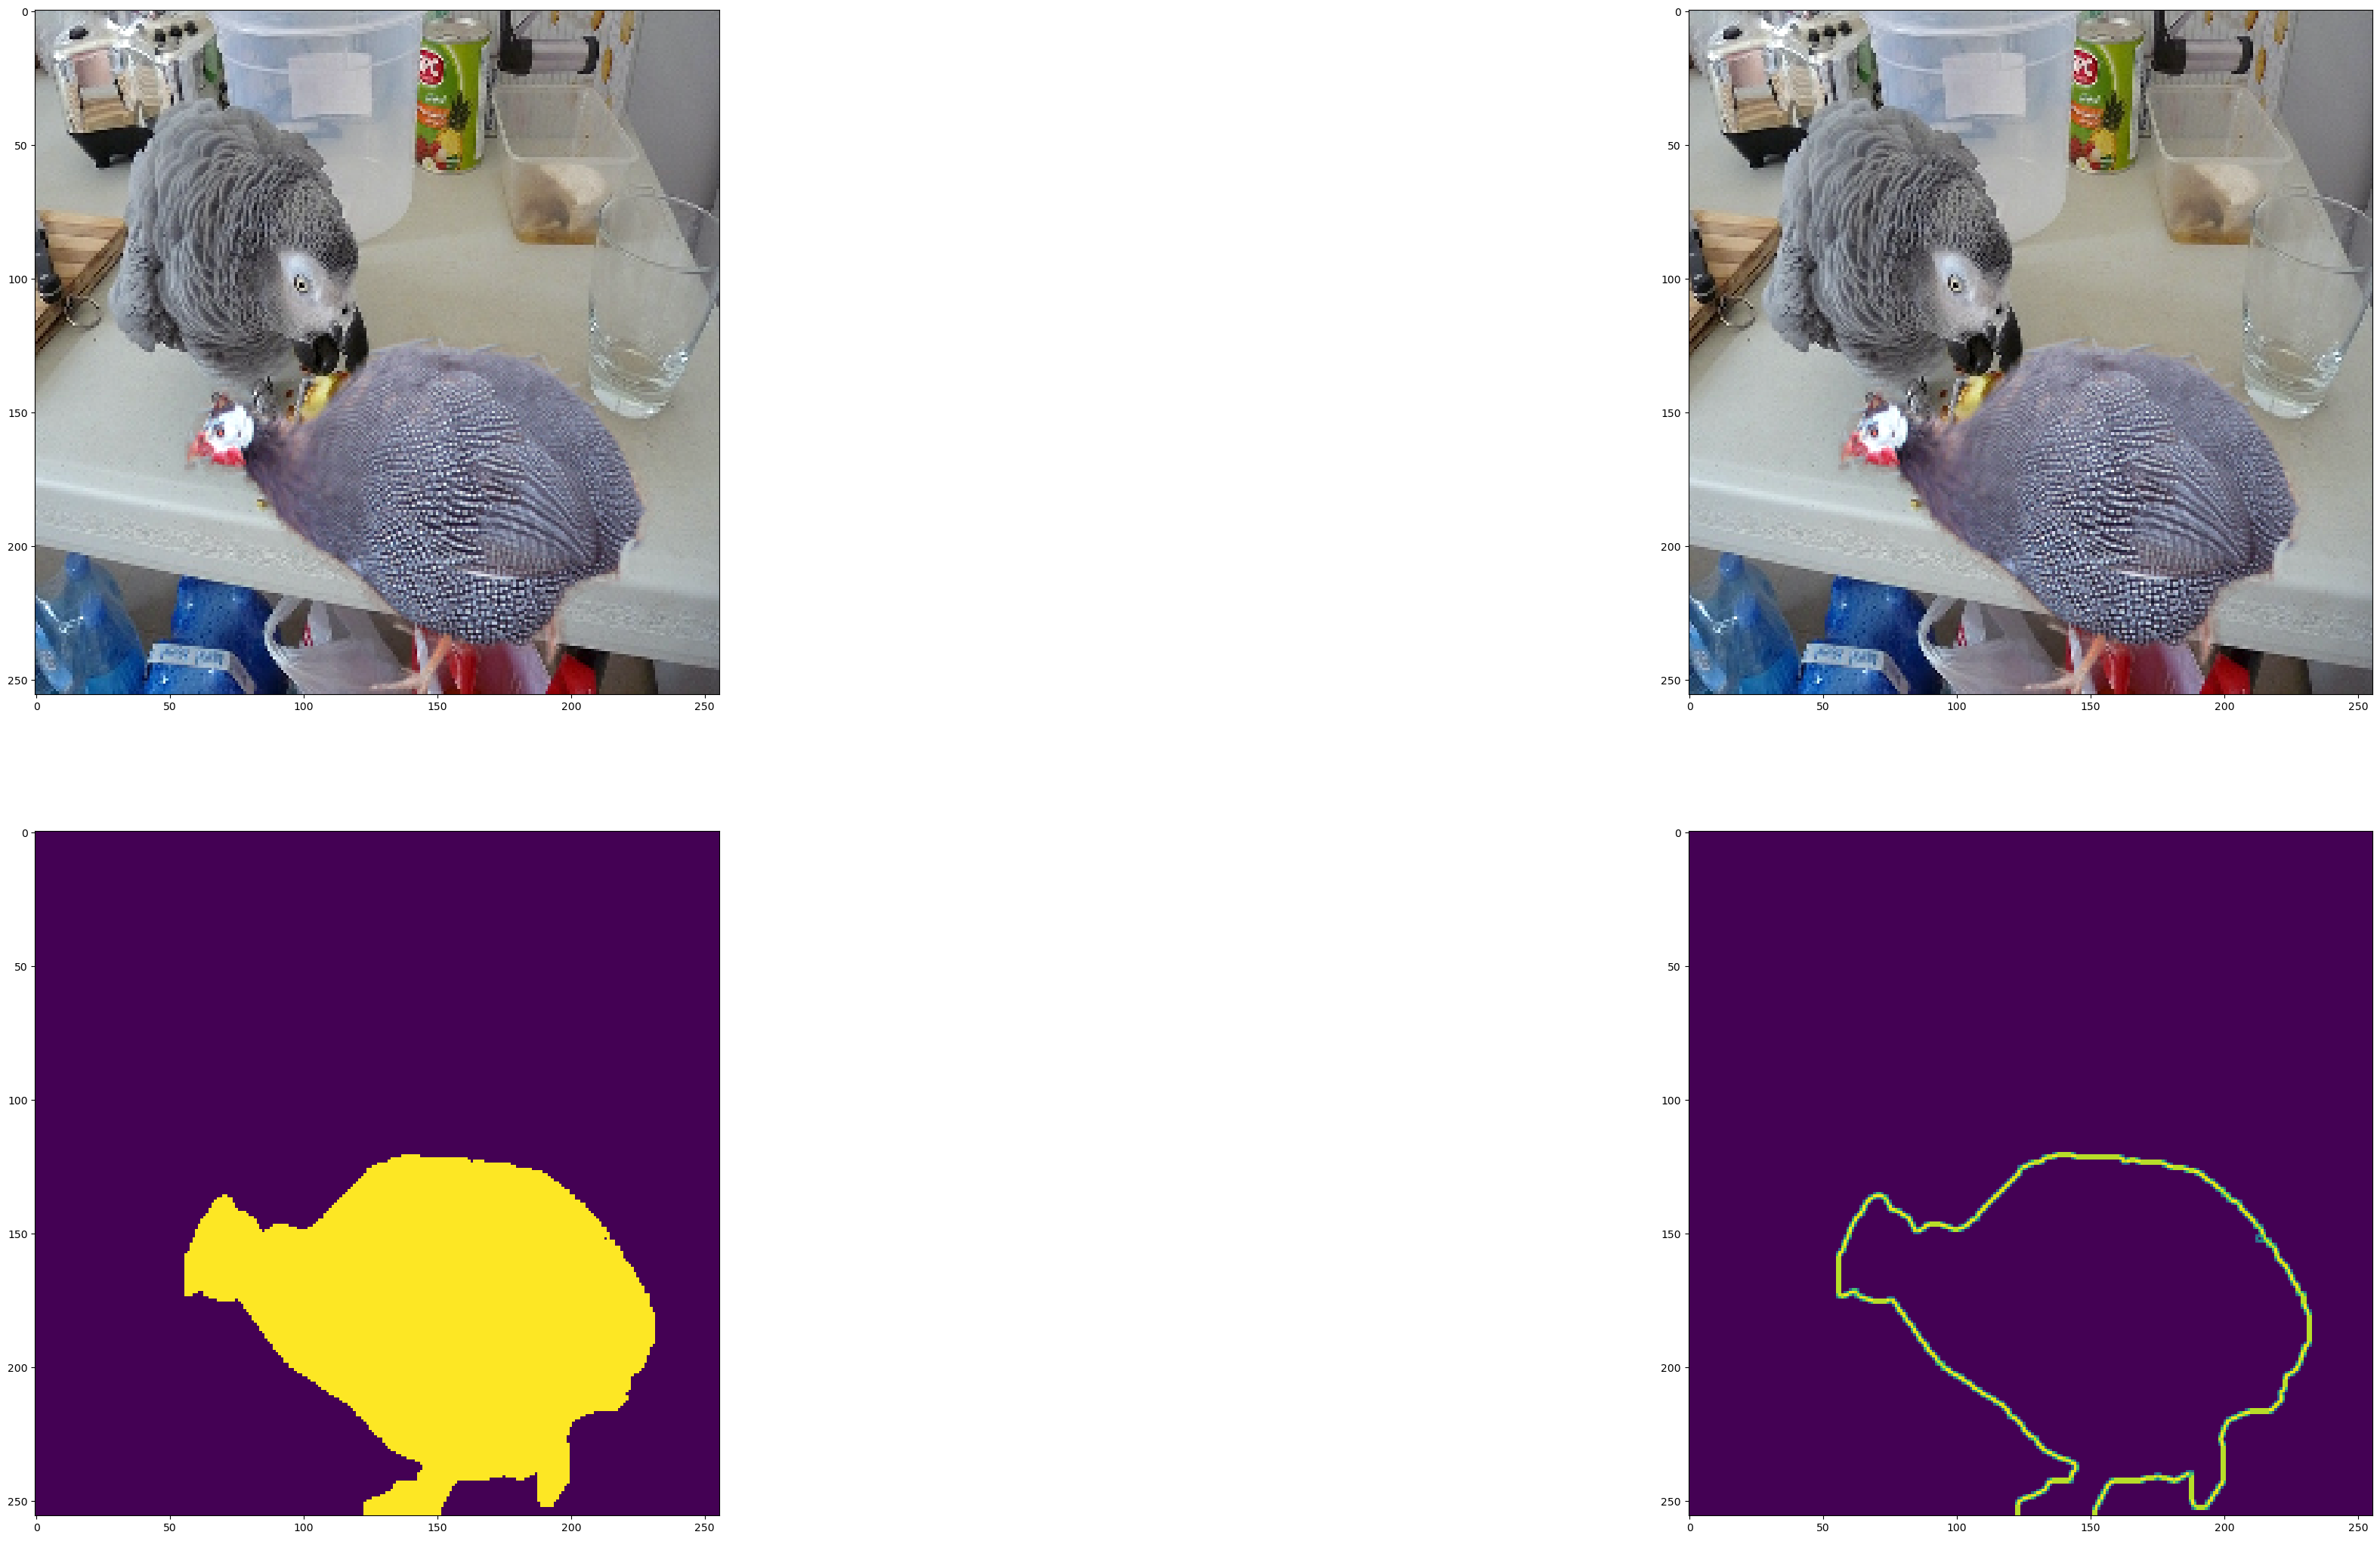

In [125]:
n = 0

# Create a figure with a specified size
plt.figure(figsize=(40, 40))

# Plot the first subplot
plt.subplot(3, 3, 1)
# Extract and normalize the image data
a = np.array(np.transpose(data1[n, :, :, :].cpu(), (1, 2, 0)) / 4)
# Display the image
plt.imshow(a[:, :, ::-1])

# Plot the second subplot
plt.subplot(3, 3, 4)
# Extract the target data from data2
cc2 = (((data2[n, 0, :, :])))  # Assuming data2 is already on the CPU
# Display the target data
plt.imshow(cc2.cpu().detach())  # Convert to CPU before using imshow

# Plot the third subplot
plt.subplot(3, 3, 3)
# Extract and normalize the image data (same as the first subplot)
a4 = np.array(np.transpose(data1[n, :, :, :].cpu(), (1, 2, 0)) / 4)
# Display the image
plt.imshow(a4[:, :, ::-1])

# Plot the fourth subplot
plt.subplot(3, 3, 6)
# Apply the Sobel edge filter to the target data (assuming edge is already on the CPU)
edge = K.filters.sobel(data2)
cc6 = np.array((edge[n, 0, :, :].cpu().detach()))
# Display the filtered target data
plt.imshow(cc6)

# Uncomment the following lines if you want to save the figure as an image
# plt.savefig('Output_image_b_' + f'{batch}' + '_number_of_epochs_' + f'{num_epochs}' + '.png')


In [130]:
torch.save(net.state_dict(), 'Model_b_'+f'{batch}'+'_epochs_number_'+f'{num_epochs}'+'.pth')

In [128]:
#print(torch.load("C://Users//yaswa//Downloads//code//Model_b_10_epochs_number_1.pth", map_location=device))

In [131]:
import pickle 
pickle.dump(net, open('C:\\Users\\yaswa\\Downloads\\code\\Model_b_'+f'{batch}'+'_epochs_number_'+f'{num_epochs}'+'.pkl', 'wb'))